In [16]:
# imports
import pandas as pd
from datetime import datetime
import finnhub
import numpy as np
import matplotlib.pyplot as plot
from sklearn.preprocessing import MinMaxScaler

In [17]:
client = finnhub.Client(api_key='bua9lb748v6q418gd0i0')

def get_candlestick_data(ticker, timeframe, start, end):
    # I think I need to add some await functionality to the finnhub API call
    data = client.stock_candles(ticker, timeframe, start, end)
    del data['s']
    df = pd.DataFrame.from_dict(data)
    df['t'] = df['t'].apply(lambda x: datetime.fromtimestamp(x))
    df = df.rename(columns={'c': 'Close', 'h': 'High', 'l': 'Low', 'o': 'Open', 't': 'Date', 'v': 'Volume'})
    df.set_index('Date', inplace=True)
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
    return df

In [18]:
amazon_data = get_candlestick_data('AMZN', 'D', 1281764208, 1603859231)
print(amazon_data)

                            Open         High          Low        Close  \
Date                                                                      
2010-08-15 17:00:00   123.610001   127.370003   123.040001   126.070000   
2010-08-16 17:00:00   127.339996   129.979996   126.790001   128.860001   
2010-08-17 17:00:00   129.250000   130.809998   128.259995   129.649994   
2010-08-18 17:00:00   129.220001   130.020004   126.820000   127.570000   
2010-08-19 17:00:00   127.199997   128.039993   126.019997   127.760002   
...                          ...          ...          ...          ...   
2020-10-21 17:00:00  3189.870117  3198.000000  3122.250000  3176.399902   
2020-10-22 17:00:00  3191.000000  3205.330078  3140.000000  3204.399902   
2020-10-25 17:00:00  3196.020020  3281.419922  3153.540039  3207.040039   
2020-10-26 17:00:00  3223.000000  3291.179932  3212.260010  3286.330078   
2020-10-27 17:00:00  3248.719971  3264.020020  3162.780029  3162.780029   

                      Vo

In [19]:
open_data = amazon_data.iloc[:, 0:5].to_numpy()
scaler = MinMaxScaler(feature_range = (0, 1))
open_data = scaler.fit_transform(open_data)

# to undo:
# open_data = scaler.inverse_transform(open_data)
# open_data = pd.DataFrame(data=open_data, index=amazon_data.index)
# print(open_data)

In [20]:
data_train = open_data[:2056]
data_test = open_data[2030:]

In [21]:
# Create x_train and y_train tensors
x_train = []
y_train = []

# ! what about stocks that don't have at least a year's worth of trading data
# 2056 - 7 = 2049
for i in range(253, 2049):
    x_train.append(data_train[i-253:i])
    y_train.append(data_train[i:i+7])

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

# x_train.shape = (1796, 253, 5)
# y_train.shape = (1796, 7, 5)

In [22]:
# Create x_test and y_test tensors
x_test = []
y_test = []

# data_test.shape = (540, 5)
for i in range(253, 533):
    x_test.append(data_test[i-253:i])
    y_test.append(data_test[i:i+7])

x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

# x_test.shape = (280, 253, 5)
# y_test.shape = (280, 7, 5)

In [23]:
y_train.shape[1]

7

In [10]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.callbacks import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

model = Sequential([
  layers.LSTM(units=300, return_sequences=False, input_shape=(253, 5)),
  layers.RepeatVector(7),
  layers.Dropout(0.2),
  layers.LSTM(units=300, return_sequences=True),
#   layers.RepeatVector(7),
  layers.Dropout(0.2),
  layers.LSTM(units=300, return_sequences=True),
#   layers.RepeatVector(7),
  layers.Dropout(0.2),
  layers.LSTM(units=300, return_sequences=True),
#   layers.RepeatVector(7),
  layers.Dropout(0.2),
#   layers.LSTM(units=200, return_sequences=False),
#   layers.RepeatVector(7),
#   layers.Dropout(0.2),
#   layers.LSTM(units=250, return_sequences=True),
#   layers.Dropout(0.2),
#   layers.LSTM(units=200, return_sequences=True),
#   layers.Dropout(0.1),
#   layers.LSTM(units=200, return_sequences=True),
#   layers.Dropout(0.1),
#   layers.LSTM(units=200, return_sequences=True),
#   layers.Dropout(0.1),
  layers.TimeDistributed(Dense(5))
])

In [ ]:
model.compile(loss="mean_squared_error", optimizer="adam")

mcp_save = ModelCheckpoint('mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
earlyStopping = EarlyStopping(monitor='val_loss', patience=200, verbose=0, mode='min')

model.fit(x_train,y_train, epochs=1000, batch_size=64, validation_split=0.15, callbacks=[mcp_save,earlyStopping])

Epoch 1/1000
24/24 [==============================] - 2s 99ms/step - loss: 0.0075 - val_loss: 0.0346
Epoch 2/1000
24/24 [==============================] - 1s 44ms/step - loss: 0.0033 - val_loss: 0.0159
Epoch 3/1000
24/24 [==============================] - 1s 44ms/step - loss: 0.0025 - val_loss: 0.0087
Epoch 4/1000
24/24 [==============================] - 1s 45ms/step - loss: 0.0023 - val_loss: 0.0064
Epoch 5/1000
24/24 [==============================] - 1s 40ms/step - loss: 0.0021 - val_loss: 0.0066
Epoch 6/1000
24/24 [==============================] - 1s 46ms/step - loss: 0.0021 - val_loss: 0.0057
Epoch 7/1000
24/24 [==============================] - 1s 43ms/step - loss: 0.0021 - val_loss: 0.0052
Epoch 8/1000
24/24 [==============================] - 1s 45ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 9/1000
24/24 [==============================] - 1s 42ms/step - loss: 0.0020 - val_loss: 0.0043
Epoch 10/1000
24/24 [==============================] - 1s 43ms/step - loss: 0.0020 - val_lo

(280, 7, 5)
[1.8198558e+03 1.8424785e+03 1.8139155e+03 1.8239771e+03 3.2000890e+06]
                            Open         High          Low        Close  \
Date                                                                      
2020-09-16 17:00:00  3009.250000  3029.429932  2972.550049  3008.729980   
2020-09-17 17:00:00  3031.739990  3037.800049  2905.540039  2954.909912   
2020-09-20 17:00:00  2906.500000  2962.000000  2871.000000  2960.469971   
2020-09-21 17:00:00  3033.840088  3133.989990  3000.199951  3128.989990   
2020-09-22 17:00:00  3120.429932  3127.000000  2992.379883  2999.860107   
2020-09-23 17:00:00  2977.790039  3069.300049  2965.000000  3019.790039   
2020-09-24 17:00:00  3054.860107  3101.540039  2999.000000  3095.129883   
2020-09-27 17:00:00  3148.850098  3175.040039  3117.169922  3174.050049   
2020-09-28 17:00:00  3175.389893  3188.260010  3132.540039  3144.879883   
2020-09-29 17:00:00  3141.139893  3212.879883  3133.989990  3148.729980   
2020-09-30 17:00

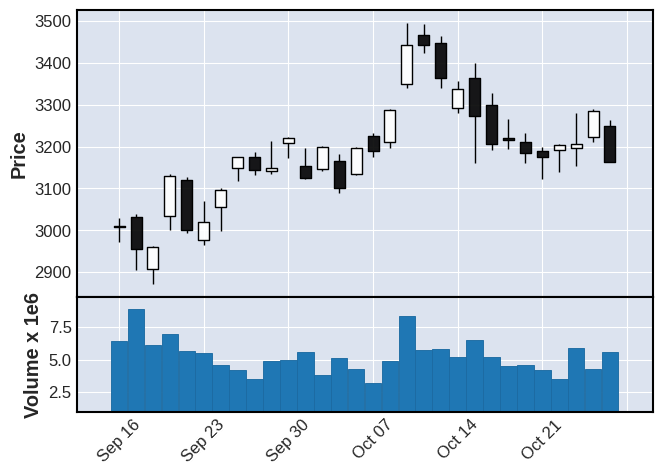

                            Open         High          Low        Close  \
Date                                                                      
2020-09-16 17:00:00  3085.135254  3111.252930  3089.237305  3091.365967   
2020-09-17 17:00:00  3111.299805  3136.076904  3115.181152  3115.516357   
2020-09-20 17:00:00  3137.808838  3163.952637  3142.593262  3144.159180   
2020-09-21 17:00:00  3160.154053  3186.641602  3165.391846  3167.275391   
2020-09-22 17:00:00  3176.659912  3202.371338  3181.798584  3182.693604   
2020-09-23 17:00:00  3203.693359  3229.849609  3209.432617  3210.620117   
2020-09-24 17:00:00  3231.913818  3257.672119  3237.885986  3238.401855   
2020-09-27 17:00:00  3190.759766  3214.402588  3195.223877  3193.764648   
2020-09-28 17:00:00  3115.443115  3139.175049  3118.898438  3118.066650   
2020-09-29 17:00:00  3047.385742  3072.500000  3050.418457  3051.554932   
2020-09-30 17:00:00  3035.091797  3060.557129  3038.038574  3039.729004   
2020-10-01 17:00:00  3027

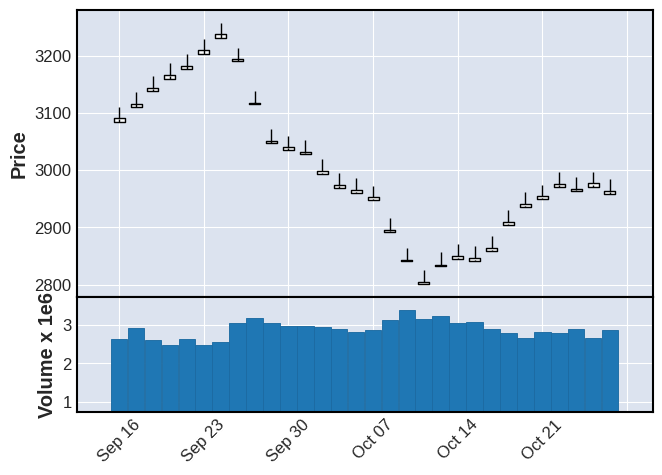

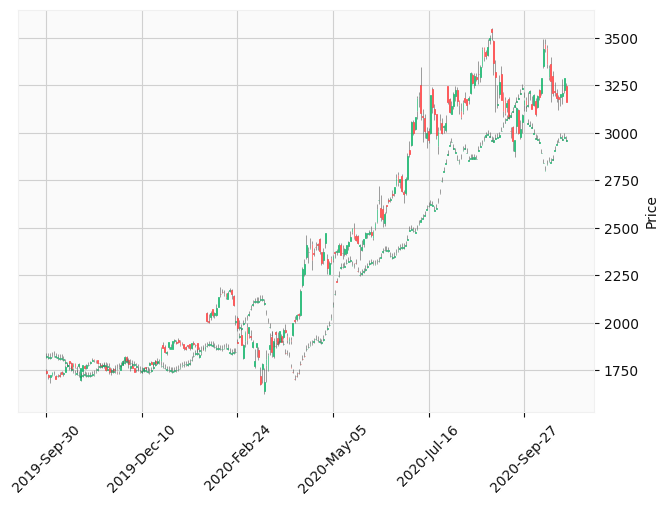

In [9]:
import matplotlib.pyplot as plt
import mplfinance as mpf
from tensorflow.keras.models import load_model
prediction_model = load_model('minimize_size_weights.hdf5')

predictions = prediction_model.predict(x_test) # print(predictions.shape) = (280, 7, 5)
predictions = scaler.inverse_transform(predictions.reshape(-1, predictions.shape[-1])).reshape(predictions.shape)


print(predictions.shape)

print(predictions[0][6])

combined = []

for i in predictions:
    combined.append(i[6])

combined = combined[:len(combined)-7]

combined = pd.DataFrame(combined, index=amazon_data.index[len(amazon_data.index)-273:])
combined = combined.rename(columns={0: 'Open', 1: 'High', 2: 'Low', 3: 'Close', 4: 'Volume'})

print(amazon_data.tail(30))
mpf.plot(amazon_data.tail(30), type='candle', volume=True)

print(combined.tail(30))
mpf.plot(combined.tail(30), type='candle', volume=True)

overlay = mpf.make_addplot(combined, type='candle', secondary_y=False)
mpf.plot(amazon_data.tail(273), addplot=overlay, type='candle', style='yahoo')

# plots = []

# for i in range(2,3):
#     dates = [amazon_data.index[j] for j in range(i,i+7)]
#     forecast = pd.DataFrame(data=predictions[i], index=dates)
#     forecast = forecast.rename(columns={0: 'Open', 1: 'High', 2: 'Low', 3: 'Close', 4: 'Volume'})
#     plots.append(mpf.make_addplot(forecast, type='candle', secondary_y=False))


# print(plots[0])
# dates = [amazon_data.index[i] for i in range(7)]
# for i in range(7):
#     dates.append(amazon_data.index[i])
    
# print(dates)

# print(predictions[0])
# print(predictions.shape)

# test = pd.DataFrame(data=predictions[0], index=dates)
# test = test.rename(columns={0: 'Open', 1: 'High', 2: 'Low', 3: 'Close', 4: 'Volume'})

# apds = [mpf.make_addplot(pd.DataFrame(data=predictions[0], index=[amazon_data.index[j] for j in range(0,7)]).rename(columns={0: 'Open', 1: 'High', 2: 'Low', 3: 'Close', 4: 'Volume'}), type='candle', secondary_y=False),
#         mpf.make_addplot(pd.DataFrame(data=predictions[1], index=[amazon_data.index[j] for j in range(1,8)]).rename(columns={0: 'Open', 1: 'High', 2: 'Low', 3: 'Close', 4: 'Volume'}), type='candle', secondary_y=False)    
# ]
# print(apds)
# apds.append(mpf.make_addplot(open_data.head(10), type='candle', secondary_y=False))

# mpf.plot(open_data.head(10), addplot=apds, type='candle')






# !! right now its converting open_data, transforming it, inverse_transforming it, and re converting. Don't run individual transforms in succession
# open_data = scaler.inverse_transform(open_data)
# open_data = pd.DataFrame(data=open_data, index=amazon_data.index)
# open_data = open_data.rename(columns={0: 'Open', 1: 'High', 2: 'Low', 3: 'Close', 4: 'Volume'})
# print(open_data)
# mpf.plot(open_data.tail(30), type='candle', volume=True, show_nontrading=True)


# fig, ax = plt.subplots(figsize=(8,4))
# plt.plot(open_data, color="red", label="True Price of Stock")
# ax.plot(range(len(y_train)+253,len(y_train)+253+len(predictions)),predictions, color='blue', label='Predicted Testing Price')
# plt.legend()

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
# X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [82]:
from datetime import datetime
import time

def get_candlestick_data(ticker, timeframe, start, end):
    data = client.stock_candles(ticker, timeframe, start, end)
    del data['s']
    df = pd.DataFrame.from_dict(data)
    df['t'] = df['t'].apply(lambda x: datetime.fromtimestamp(x))
    df = df.rename(columns={'c': 'Close', 'h': 'High',
                            'l': 'Low', 'o': 'Open', 't': 'Date', 'v': 'Volume'})
    df.set_index('Date', inplace=True)
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
    return df


def stock_data_253(ticker):
    current_time = int(time.time())
    prev_time = current_time - 46656000
    df = get_candlestick_data(ticker, 'D', prev_time, current_time)
    df = df.iloc[len(df)-253:]
    return df


def get_prediction(ticker):
    data = stock_data_253(ticker)
    open_data = data.iloc[:, 0:5].to_numpy()
    scaler = MinMaxScaler(feature_range = (0, 1))
    open_data = scaler.fit_transform(data)
    x_test = [open_data[0:253]]
    x_test = np.asarray(x_test)
    model = load_model('minimize_size_weights.hdf5')
    stock_prediction = model.predict(x_test)
    stock_prediction = scaler.inverse_transform(stock_prediction.reshape(-1, stock_prediction.shape[-1])).reshape(stock_prediction.shape)
    return stock_prediction[0]


def get_prediction_df(stock_prediction):
    prediction_df = [i for i in stock_prediction]
    date_index = []
    for i in range(7):
        date_index.append(datetime.fromtimestamp((i*86400) + int(time.time()))) 
    prediction_df = pd.DataFrame(data=prediction_df, index=date_index)
    prediction_df = prediction_df.rename(columns={0: 'Open', 1: 'High', 2: 'Low', 3: 'Close', 4: 'Volume'})
    return prediction_df

[[1.11824135e+02 1.12456352e+02 1.06485550e+02 1.09387810e+02
  1.32026480e+08]
 [1.10059082e+02 1.10716820e+02 1.04838470e+02 1.07643509e+02
  1.14732816e+08]
 [1.11475983e+02 1.12200905e+02 1.06274117e+02 1.09049927e+02
  1.02675760e+08]
 [1.11389145e+02 1.12133156e+02 1.06218452e+02 1.08981606e+02
  9.69276240e+07]
 [1.11472496e+02 1.12217918e+02 1.06313766e+02 1.09073647e+02
  9.46434880e+07]
 [1.11541451e+02 1.12274246e+02 1.06382858e+02 1.09150650e+02
  9.36011920e+07]
 [1.11602783e+02 1.12314087e+02 1.06432159e+02 1.09221848e+02
  9.30399120e+07]]


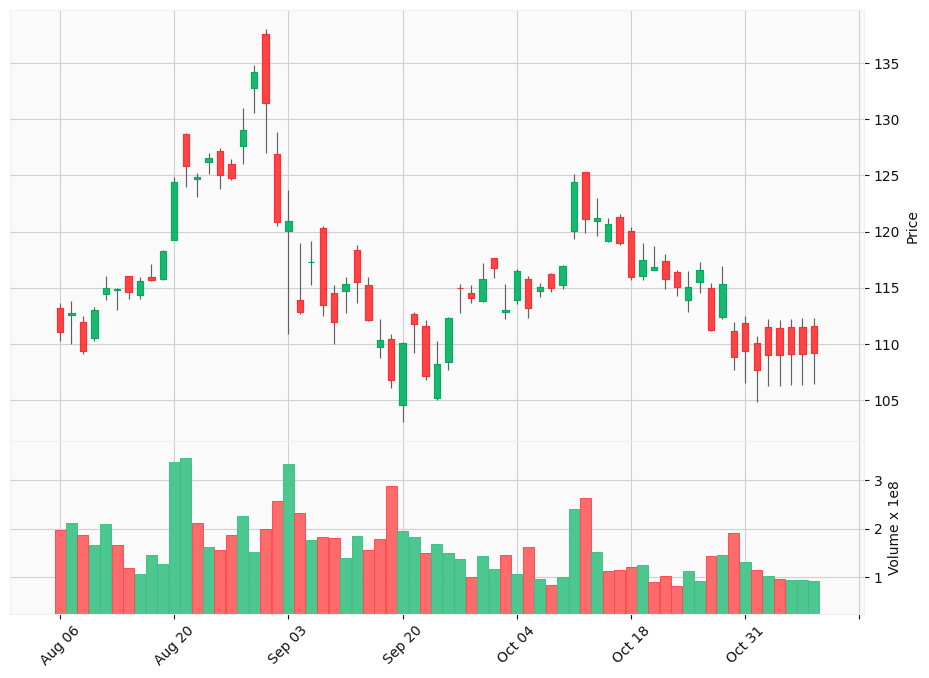

In [99]:
kwargs = dict(type='candle',volume=True,figratio=(11,8),figscale=1.5)

target_stock_prediction = get_prediction('AAPL')
target_stock_prediction_df = get_prediction_df(target_stock_prediction)

print(target_stock_prediction)

combined_df = stock_data_253('AAPL').tail(60).append(target_stock_prediction_df)
mpf.plot(combined_df, **kwargs, style='yahoo')